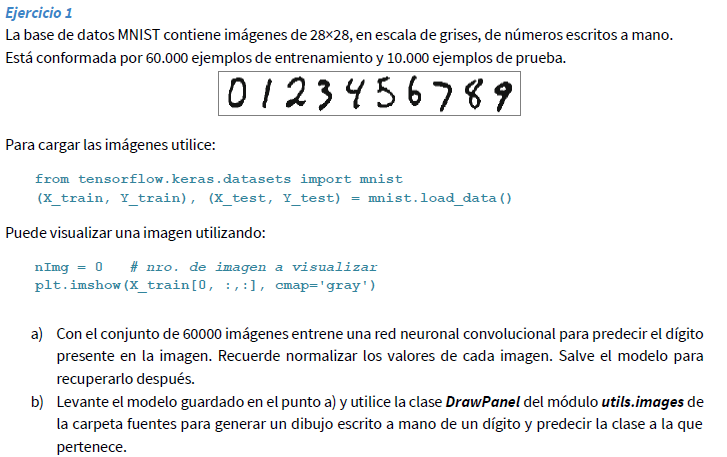

## Preparo dataset

In [30]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import numpy as np

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Y_train= to_categorical(np.array(Y_train))
Y_test = to_categorical(np.array(Y_test))

# dimension de las imagenes sacadas del primer ejmeplo
IMG_SHAPE = X_train[0].shape # (28,28)
TARGET_CNT= len(Y_train[0])  # 10 dígitos/clases

# nro. de imagen a visualizar
#plt.imshow(X_train[0, :,:], cmap='gray')

# normalización
X_train = X_train / 255
X_test  = X_test  / 255


## Genero modelo

In [31]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential


# %% Construccion del modelo
model = Sequential()

'''model.add(Conv2D(16, kernel_size=(3,3), strides=(2,2), activation='relu', input_shape=[*IMG_SHAPE, 1] ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, kernel_size=(3,3), strides=(2,2), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(TARGET_CNT, activation='softmax'))

'''
model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=[*IMG_SHAPE, 1] ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(100, activation='leaky_relu'))
model.add(Dense(TARGET_CNT, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        73792     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 100)              

## Entreno modelo

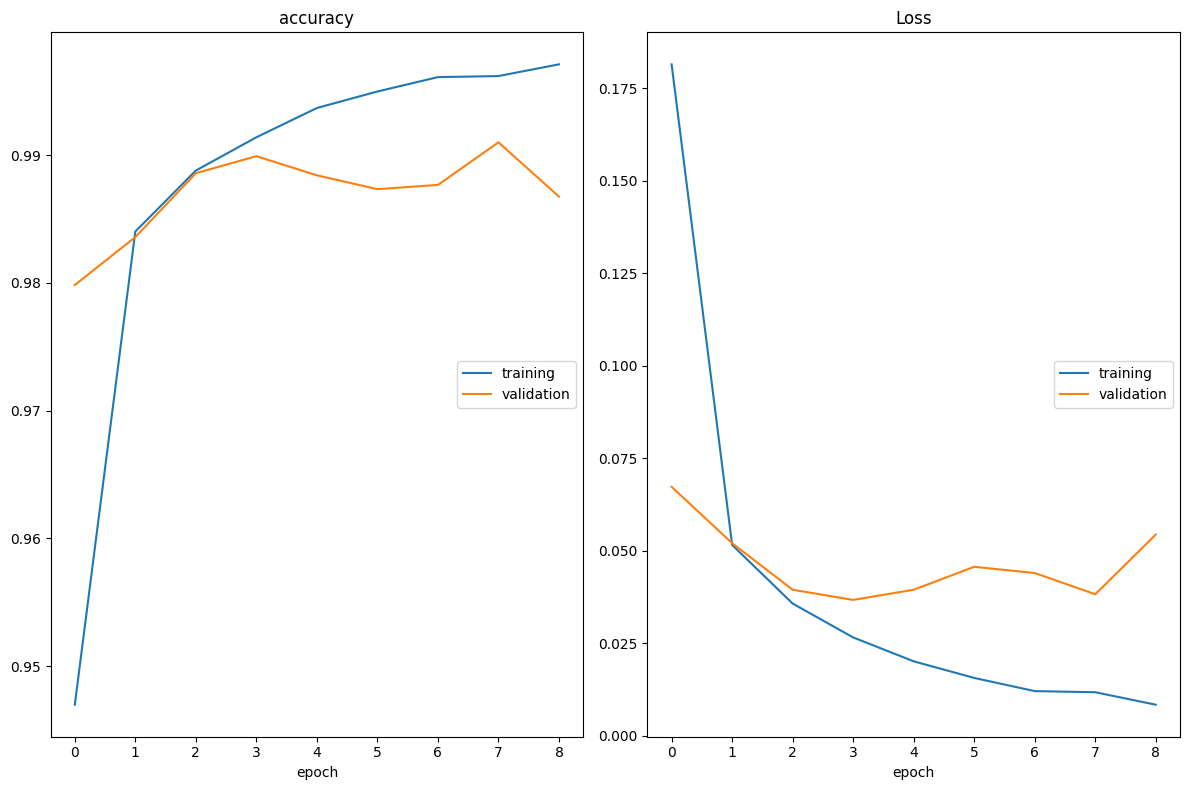

accuracy
	training         	 (min:    0.947, max:    0.997, cur:    0.997)
	validation       	 (min:    0.980, max:    0.991, cur:    0.987)
Loss
	training         	 (min:    0.008, max:    0.181, cur:    0.008)
	validation       	 (min:    0.037, max:    0.067, cur:    0.054)
480/480 [==============================] - 3s 6ms/step - loss: 0.0083 - accuracy: 0.9971 - val_loss: 0.0544 - val_accuracy: 0.9868
(60000, 28, 28)
1875/1875 [==============================] - 2s 1ms/step

Efectividad del modelo con datos de entrenamiento:  99.36%
Efectividad del modelo con datos de Prueba.......:  99.00%


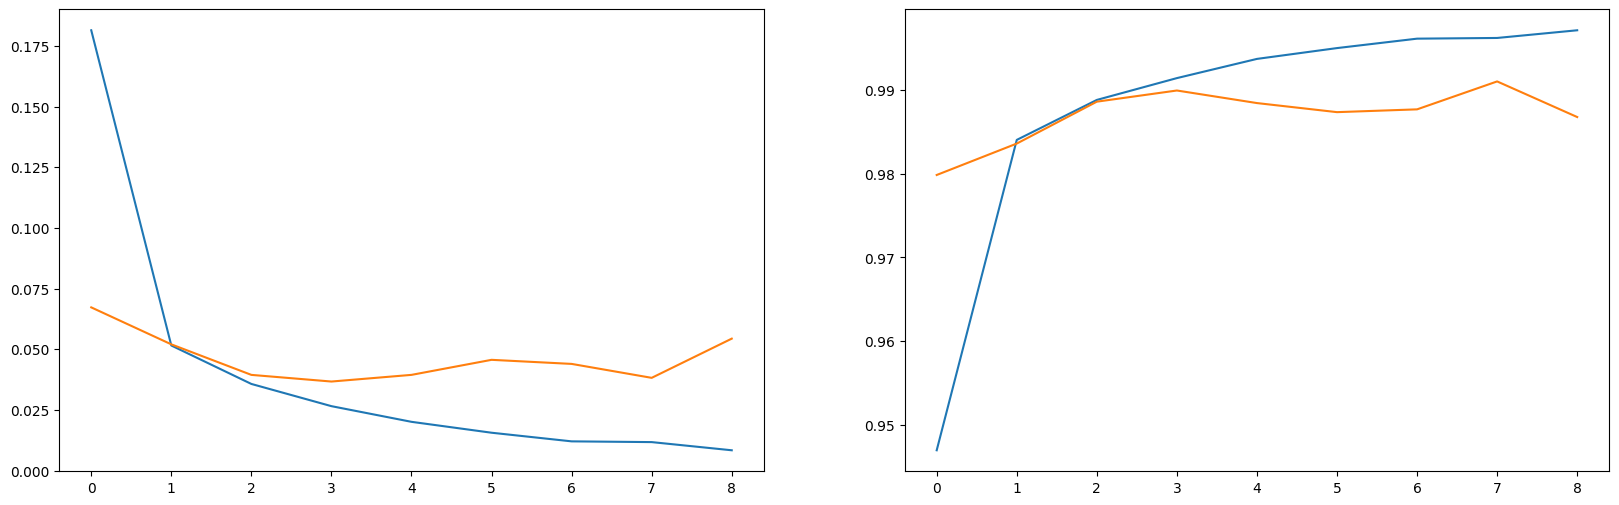

<Figure size 640x480 with 0 Axes>

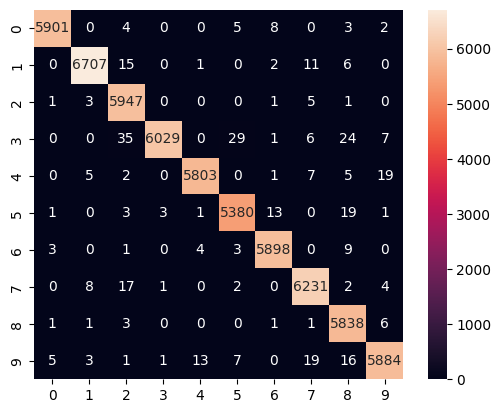

In [32]:
import seaborn as sns
from sklearn import metrics
import tensorflow as tf

LOTES  = 100
EPOCAS = 25
PACIENCIA = 5 # Una buena regla es que sea del 10% al 20% de las epocas (siempre arrancar con menos)

from livelossplot import PlotLossesKeras

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True)

# %% Entrenamiento del modelo usando datos de entrenamiento y validacion
H = model.fit(x=X_train, y=Y_train, batch_size=LOTES,
              epochs=EPOCAS, validation_split=0.2, callbacks=[PlotLossesKeras(), early_stop], verbose=1)


fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")


print (X_train.shape)
pred = model.predict(X_train)

cm = metrics.confusion_matrix(np.argmax(Y_train, axis=1), np.argmax(pred, axis=1))
plt.figure()
sns.heatmap(cm, square=True,  annot=True, fmt='d')


# %% evalua el modelo para entrenamiento y testeo
pred = model.evaluate(X_train, Y_train, verbose=0)
print("\nEfectividad del modelo con datos de entrenamiento: %6.2f%%" % (pred[1]*100))

# evalua el modelo con los datos de validacion
pred = model.evaluate(X_test, Y_test, verbose=0)
print("Efectividad del modelo con datos de Prueba.......: %6.2f%%" % (pred[1]*100))

## Salvo el modelo

In [34]:
model.save('MNIST_conv_model.keras')

## Recupero modelo

In [35]:
from tensorflow.keras.models import load_model

model = load_model('MNIST_conv_model.keras')

## Dibujo digito y realizo prediccion

In [36]:
import pygame
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

# Inicializar pygame
pygame.init()

# Dimensiones del panel de dibujo (ajustado para 200x200 píxeles)
WIDTH, HEIGHT = 200, 200
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)

# Crear la pantalla
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Dibuja un dígito")

# Llenar la pantalla de blanco
screen.fill(WHITE)

# Variable para salir del bucle
drawing = False

def draw_circle(screen, x, y):
    pygame.draw.circle(screen, BLACK, (x, y), 10)

# Bucle principal de pygame
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        # Iniciar el dibujo al hacer clic
        if event.type == pygame.MOUSEBUTTONDOWN:
            drawing = True

        # Detener el dibujo al soltar el botón
        if event.type == pygame.MOUSEBUTTONUP:
            drawing = False

        # Dibujar mientras el mouse se mueve y el botón está presionado
        if event.type == pygame.MOUSEMOTION and drawing:
            x, y = event.pos
            draw_circle(screen, x, y)

    pygame.display.update()

# Guardar la imagen dibujada
pygame.image.save(screen, "digit.png")

# Cerrar pygame
pygame.quit()

# Cargar la imagen y redimensionarla a 28x28 para el modelo
img = Image.open("digit.png").convert('L')  # Convertir a escala de grises
img = img.resize((28, 28))  # Redimensionar a 28x28
img_array = np.array(img)

# Invertir los colores (si lo dibujas en negro sobre fondo blanco)
img_array = 255 - img_array

# Normalizar la imagen
img_array = img_array / 255.0

# Redimensionar la imagen para que tenga la forma correcta (1, 28, 28, 1)
img_array = img_array.reshape(1, 28, 28, 1)


# Hacer la predicción
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

print(f"El dígito predicho es: {predicted_class[0]}") 

1/1 [==============================] - 0s 117ms/step
El dígito predicho es: 9


## **!!! No me reconoce el 9**

## Modifique el stride y agregue mas capas, ahora funciona mejor &#128512;